## Open3Dとは

PCL(Point Cloud Library)に不満を覚えて作成したライブラリらしい。

- Python API充実
- ドキュメント充実
- ビューワが使いやすい

が特徴。点群処理アルゴリズム自体はPCLのほうがまだ充実しているようなので併用か。

In [119]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [120]:
import open3d as o3d

## 基本
ポイントクラウドの操作とか。まずポイントクラウドを読み込む。

In [121]:
pcd = o3d.io.read_point_cloud("../Open3D/examples/test_data/fragment.pcd")

RGBとDepth画像をセットにして読み込む。

In [122]:
color_raw = o3d.io.read_image("../Open3D/examples/test_data/RGBD/color/00000.jpg")
depth_raw = o3d.io.read_image("../Open3D/examples/test_data/RGBD/depth/00000.png")
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)

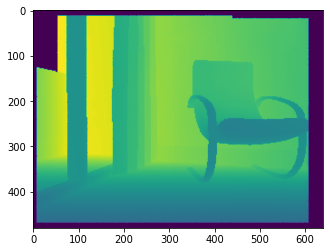

In [123]:
plt.imshow(rgbd.depth)

カメラパラメータがあれば Point Cloudに変換できる。

In [124]:
intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
#draw_geometries([pcd],width=640,height=480)  # ビューワの解像度指定

PointCloudがほしいだけなら、RGBは不要で、depthとカメラパラメータだけでいい。

In [125]:
pcd2=o3d.geometry.PointCloud.create_from_depth_image(depth_raw,intrinsic)

PinholeCameraIntrinsicクラスは、幅・高さ・変換行列のようなので、openCVのキャリブ結果から簡単に引き出せるかな。

In [126]:
print(intrinsic.width, "\n" , intrinsic.height, "\n", intrinsic.intrinsic_matrix)

640 
 480 
 [[525.    0.  319.5]
 [  0.  525.  239.5]
 [  0.    0.    1. ]]


点群をNDArray()として取り出すのは下記のようにする。

In [127]:
p=np.asarray(pcd2.points)

逆に、点群データからPointCloudクラスを作るには下記。

In [128]:
xyz=[[-1,-1,1],[1,1,1],[1,-1,1],[-1,1,1]]
pcd3= o3d.geometry.PointCloud()
pcd3.points = o3d.utility.Vector3dVector(xyz)

## オフラインレンダリング

ビューワ(draw_geometries)にはいろんなキーバインドがある。[h]キーを押すとコンソールにヘルプが表示される。
[o]キーを押すとjson形式でレンダリング設定をセーブするらしい。

画像のワンショットを取るのは下記でいけそう。レンダリング設定のjsonを読みたい場合はコメントアウトしているところを直せばよし。
[OSMesaを使う方法もある](http://www.open3d.org/docs/tutorial/Advanced/headless_rendering.html)がビルドめんどくさいしいいや。

In [129]:
def capture_img(pcds):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=640,height=480)
    #vis.get_render_option().load_from_json(RENDER_JSON_FILE)
    for pcd in pcds:
        vis.add_geometry(pcd)
    img=vis.capture_screen_float_buffer(True)
    vis.destroy_window()
    return img

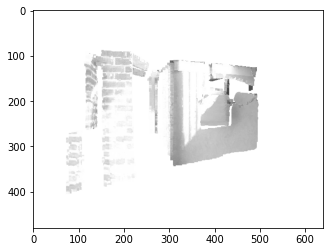

In [130]:
img=capture_img([pcd])
plt.imshow(img)

ダウンサンプリングして表示

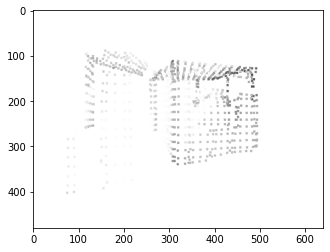

In [131]:
plt.imshow( capture_img( [pcd.voxel_down_sample(voxel_size = 0.1)]))

## RGBOdmetry
２枚のRGBD画像の間の変換行列を求める。SLAMとかで使う。

## KDTree
データ間の距離を基準にツリー状に並べたデータ構造で表現する。
近傍点の探索等を高速化するため。

## Registration
位置合わせ。初期値を必要とするものをlocal registration、必要としないものをglobal registrationと呼ぶ。globalは計算量の関係から荒いポイントクラウドで行い、globalで求まった解を初期値にしてlocal registrationを行う。

- local
    - ICP
    -  Colored point cloud registration
- global
    - RANSAC　遅いらしい
    - Zhou2016 早いらしい

RANSAC+ICPの例が下記にある。

https://www.slideshare.net/SSII_Slides/3d-101077557
https://github.com/sakizuki/SSII2018_Tutorial_Open3D/blob/master/Python/keypoint_matching.py

In [132]:
import copy

#sourceをtransformationによって剛体変換してtargetと一緒に表示
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    plt.imshow( capture_img([source_temp, target_temp]))
    
#キーポイント検出，法線推定，特徴記述
# orientをFalseにすることで，法線方向の修正をオフにできます．
def preprocess_point_cloud(pcd, voxel_size, orient=True):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_kp = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    viewpoint = np.array([0.,0.,100.], dtype='float64')
    pcd_kp.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius = radius_normal, max_nn = 30))
    if orient == True:
        pcd_kp.orient_normals_towards_camera_location( camera_location = viewpoint )        
    else:
        print("Orient is not applied.")

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd_kp,o3d.geometry.KDTreeSearchParamHybrid(radius = radius_feature, max_nn = 200))
    return pcd_kp, pcd_fpfh

#RANSACによるレジストレーション
def execute_global_registration(
        source_kp, target_kp, source_fpfh, target_fpfh, voxel_size):
    print(source_fpfh)
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_kp, target_kp, source_fpfh, target_fpfh,
            True,
            distance_threshold,
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 
            ransac_n=4,
            checkers=[o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(40000, 500)
            )
    return result

#ICPによるリファイン
def refine_registration(source, target, trans, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(source, target, 
            distance_threshold, 
            trans,
            #estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane
            )
    return result

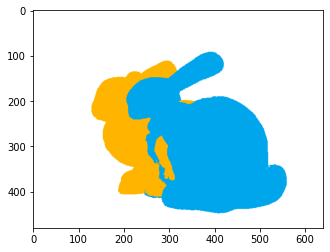

In [133]:
source = o3d.io.read_point_cloud("./data/bun000.ply")
target = o3d.io.read_point_cloud("./data/bun045.ply")

draw_registration_result(source, target, np.identity(4))

WARNING - 2021-09-06 21:48:14,702 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


:: Downsample with a voxel size 0.010.
:: Compute FPFH feature with search radius 0.050.
:: Downsample with a voxel size 0.010.
:: Compute FPFH feature with search radius 0.050.


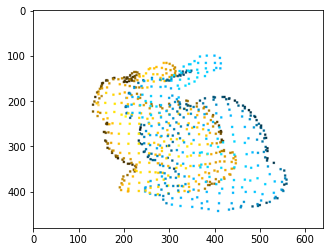

In [134]:
#キーポイント検出と特徴量抽出
voxel_size = 0.01
source_kp, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_kp, target_fpfh = preprocess_point_cloud(target, voxel_size)
draw_registration_result(source_kp, target_kp, np.identity(4))

Feature class with dimension = 33 and num = 376
Access its data via data member.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.010,
   we use a liberal distance threshold 0.015.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.004.


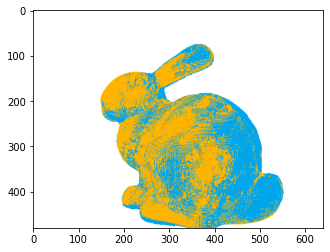

In [118]:
#RANSACによる姿勢推定
result_ransac = execute_global_registration(source_kp, target_kp,
            source_fpfh, target_fpfh, voxel_size)

#ICPによる微修正
result_icp = refine_registration(source, target, result_ransac.transformation, voxel_size)
draw_registration_result(source, target, result_icp.transformation)

複数視点のPointCloudを一つにまとめるmultiway registrationというやつもある。

## Segmentation

セグメンテーションは未実装みたい。python-pclはいちおう対応しているようだ。